## Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [2]:
# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, :1]
X_train, X_test, y_train, y_test = train_test_split(diabetes_X,
                                                    diabetes_y,
                                                    test_size=0.33,
                                                    random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
class LinearRegressor:
    def __init__(self, l2=0., lr=0.003):
        self.theta = None
        self.beta = None
        self.lr = lr
        self.l2 = l2

    def shuffle_data(self, X, y):
        x_temp = np.concatenate([X, np.expand_dims(y, axis=1)], axis=1)
        np.random.shuffle(x_temp)
        X, y = x_temp[:, :-1], np.squeeze(x_temp[:, -1])
        return X, y

    def create_datagen(self, X, y=None, batch_size=16):
        for i in range(0, len(X), batch_size):
            x_batch = X[i:i+batch_size]

            if y is not None:
                y_batch = y[i:i+batch_size]
                yield x_batch, y_batch
            else:
                yield x_batch

    def predict_batch(self, X):
        return np.dot(X, self.theta) + self.beta

    def compute_loss(self, h, y):
        m = len(h)
        z = (1. / m) * sum((y - h)**2)
        z += (self.l2 / 2.) * np.linalg.norm(self.theta, 2)
        return z

    def compute_grad(self, h, y, X):
        m = len(h)
        theta_grad = (-2. / m) * sum(np.dot(X.T, (y - h)))
        b_grad = (-2. / m) * sum(y - h)
        return theta_grad, b_grad

    def update_weights(self, theta_grad, b_grad):
        self.theta -= self.lr * theta_grad
        self.beta -= self.lr * b_grad

    def fit(self, X_train, y_train, epochs=100, batch_size=16, tol=0.0001, shuffle=True):
        d = X_train.shape[1]
        self.theta = np.random.rand(d)
        self.beta = np.random.rand(1)
        avg_loss = float("inf")
        losses = []
        epoch = 0
        while epoch < epochs and avg_loss > tol:
            datagen = self.create_datagen(X_train, y_train, batch_size)
            epoch_losses = []
            for i, (x, y) in enumerate(datagen):
                y_pred = self.predict_batch(x)
                
                loss = self.compute_loss(y_pred, y)
                epoch_losses.append(loss)

                theta_grad, b_grad = self.compute_grad(y_pred, y, x)
                self.update_weights(theta_grad, b_grad)

            avg_loss = sum(epoch_losses) / (i + 1)
            losses.append(avg_loss)

            if shuffle:
                X_train, y_train = self.shuffle_data(X_train, y_train)
            
            epoch += 1

        return losses

    def predict(self, X_test, batch_size=16):
        assert self.theta is not None
        datagen = self.create_datagen(X_test, batch_size=batch_size)
        y_ret = []
        for x in datagen:
            y_pred = self.predict_batch(x)
            y_ret.append(y_pred)

        return np.concatenate(y_ret, axis=0)

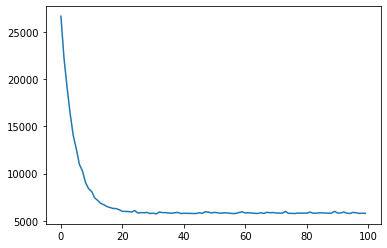

In [4]:
linreg = LinearRegressor(l2=0.003)
losses = linreg.fit(X_train, y_train, epochs=100, batch_size=16)
plt.plot(range(len(losses)), losses)

In [5]:
y_pred = linreg.predict(X_test)
mean_squared_error(y_test, y_pred)

5494.93334980309

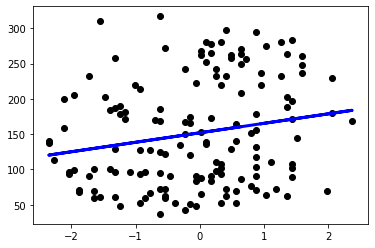

In [6]:
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)